In [23]:
import os

video_path = '/kaggle/input/video03/video1_2.mp4' 
print("Exists?", os.path.exists(video_path))


Exists? True


In [24]:
import cv2

cap = cv2.VideoCapture(video_path)
ret, first_frame = cap.read()

if not ret:
    raise RuntimeError("Failed to read first frame from video")

cap.release()


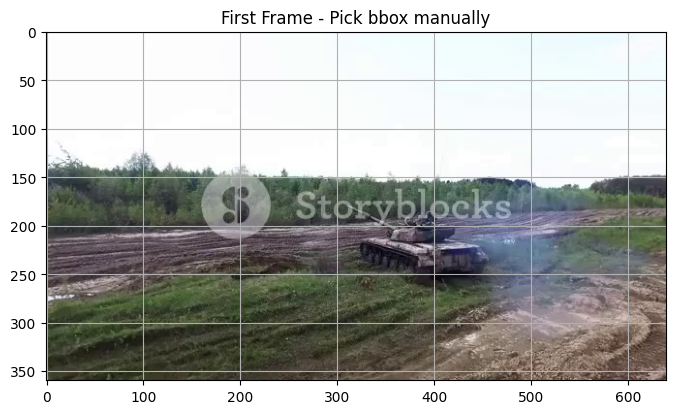

In [25]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 5))
plt.imshow(cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB))
plt.title("First Frame - Pick bbox manually")
plt.grid()
plt.show()


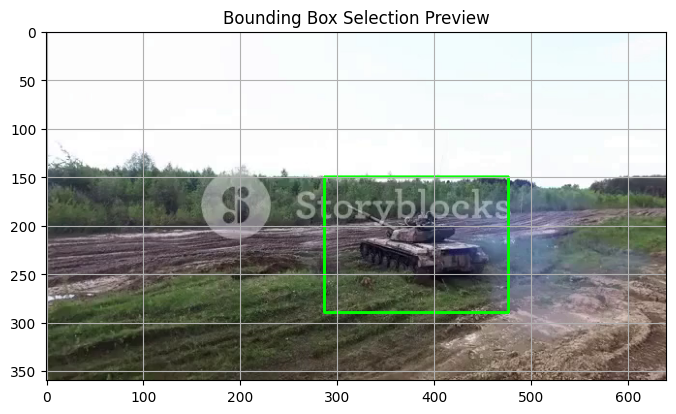

In [27]:
bbox = (287, 150, 190, 140) 

x, y, w, h = bbox
first_frame_copy = first_frame.copy()
cv2.rectangle(first_frame_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.figure(figsize=(8, 5))
plt.imshow(cv2.cvtColor(first_frame_copy, cv2.COLOR_BGR2RGB))
plt.title("Bounding Box Selection Preview")
plt.grid()
plt.show()


In [28]:
import os
import shutil

work_dir = "/kaggle/working"

for item in os.listdir(work_dir):
    item_path = os.path.join(work_dir, item)
    if os.path.isfile(item_path) or os.path.islink(item_path):
        os.unlink(item_path)
    elif os.path.isdir(item_path):
        shutil.rmtree(item_path)

print("Kaggle working directory cleaned.")


Kaggle working directory cleaned.


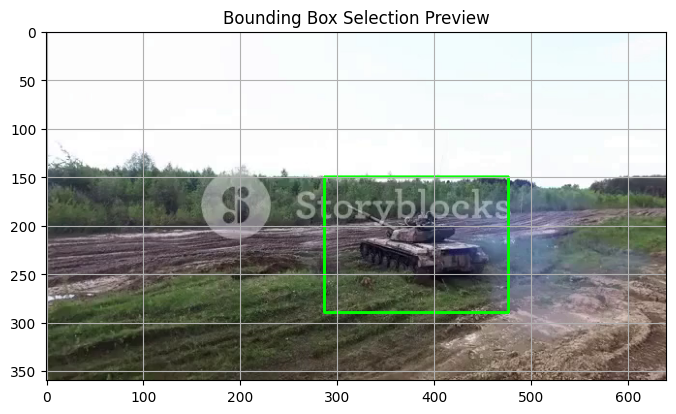

=== Frame Properties ===
Frame width: 640 px
Frame height: 360 px
Number of channels: 3

=== Bounding Box Properties ===
Top-left corner (x, y): (287, 150)
Width: 190 px
Height: 140 px
Bottom-right corner (x+w, y+h): (477, 290)
Center of bbox: (382, 220)


In [29]:
import cv2
import matplotlib.pyplot as plt

# Example bbox and frame
x, y, w, h = bbox

# Load or define your first frame (assuming first_frame is already read)
# first_frame = cv2.imread("path_to_frame.jpg")  # if reading from file

# Make a copy to draw bbox
first_frame_copy = first_frame.copy()
cv2.rectangle(first_frame_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Show the frame with bbox
plt.figure(figsize=(8, 5))
plt.imshow(cv2.cvtColor(first_frame_copy, cv2.COLOR_BGR2RGB))
plt.title("Bounding Box Selection Preview")
plt.grid()
plt.show()

# -------------------------------
# Print properties
# -------------------------------
frame_height, frame_width = first_frame.shape[:2]

print("=== Frame Properties ===")
print(f"Frame width: {frame_width} px")
print(f"Frame height: {frame_height} px")
print(f"Number of channels: {first_frame.shape[2]}")  # usually 3 for BGR

print("\n=== Bounding Box Properties ===")
print(f"Top-left corner (x, y): ({x}, {y})")
print(f"Width: {w} px")
print(f"Height: {h} px")
print(f"Bottom-right corner (x+w, y+h): ({x + w}, {y + h})")

# Optional: compute center of bbox
cx = x + w // 2
cy = y + h // 2
print(f"Center of bbox: ({cx}, {cy})")


In [30]:
import cv2, numpy as np, time, os

# -------------------------------------------------
# 1️⃣  Settings
# -------------------------------------------------
video_out_path  = '/kaggle/working/video3_1_17.mp4'

initial_bbox    = bbox        # x, y, w, h
search_expansion = 80                         # a bit larger than before
method_default   = cv2.TM_CCOEFF_NORMED        # will be overridden per‑frame
confidence_thr   = 0.55                       # min correlation to accept a match
update_every_n   = 10                         # re‑extract template every N frames

# -------------------------------------------------
# 2️⃣  Open video & writer
# -------------------------------------------------
cap = cv2.VideoCapture(video_path)
fps   = cap.get(cv2.CAP_PROP_FPS)
W     = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H     = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

out = cv2.VideoWriter(
    video_out_path,
    cv2.VideoWriter_fourcc(*'mp4v'),
    fps,
    (W, H)
)

# -------------------------------------------------
# 3️⃣  Grab first frame, initialise template (gray)
# -------------------------------------------------
ret, first_frame = cap.read()
if not ret:
    raise RuntimeError('Cannot read first frame')

x, y, w, h = initial_bbox
template_bgr = first_frame[y:y+h, x:x+w].copy()
template = cv2.cvtColor(template_bgr, cv2.COLOR_BGR2GRAY)

# Helper: decide which matching method works best for the current template
def choose_method(tmpl):
    # compute mean & stddev (single channel)
    mean, std = cv2.meanStdDev(tmpl)
    mean = float(mean)
    std  = float(std)
    # low‑contrast → use CCOEFF, otherwise SQDIFF
    if std < 140:
        m = cv2.TM_CCOEFF_NORMED
    else:
        m = cv2.TM_SQDIFF_NORMED
    # bright template → invert both sides (helps a lot for high‑intensity objects)
    if mean > 65:
        tmpl[:] = cv2.bitwise_not(tmpl)
        invert = True
    else:
        invert = False
    return m, invert

method, invert_template = choose_method(template)

# -------------------------------------------------
# 4️⃣  Main processing loop
# -------------------------------------------------
frame_idx = 0
start_time = time.time()

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # ---- 4.1  Work in gray for matching
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # ---- 4.2  Build search region (clamp to image borders)
    x1 = max(x - search_expansion, 0)
    y1 = max(y - search_expansion, 0)
    x2 = min(x + w + search_expansion, W)
    y2 = min(y + h + search_expansion, H)
    search_region = gray[y1:y2, x1:x2]

    # ---- 4.3  (Optional) invert search region if we inverted the template
    if invert_template:
        search_region = cv2.bitwise_not(search_region)

    # ---- 4.4  Template matching
    res = cv2.matchTemplate(search_region, template, method)

    # For SQDIFF the *minimum* is the best match, for the others the *maximum*
    if method in (cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED):
        min_val, _, min_loc, _ = cv2.minMaxLoc(res)
        best_val = min_val
        best_loc = min_loc
        # Convert to a “confidence‑like” value (higher = better)
        # For SQDIFF_NORMED the range is [0,1] where 0 is perfect.
        confidence = 1.0 - best_val
    else:
        _, max_val, _, max_loc = cv2.minMaxLoc(res)
        best_val = max_val
        best_loc = max_loc
        confidence = best_val

    # ---- 4.5  Reject low‑confidence matches → keep previous box
    if confidence < confidence_thr:
        # optionally enlarge the search window for the next frame
        search_expansion = min(search_expansion + 10, 150)
        # keep old (x,y) – do NOT update
        # (you could also set a flag to draw a red “lost” marker)
    else:
        # Accept the match and reset search window size
        search_expansion = 80
        x = x1 + best_loc[0]
        y = y1 + best_loc[1]

    # ---- 4.6  Draw everything on the *color* frame
    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255), 3)

    # cross‑hair & circle (scaled to the current bbox size)
    cx, cy = x + w // 2, y + h // 2
    cross = max(5, w // 8)
    radius = max(8, w // 6)
    cv2.line(frame, (cx - cross, cy), (cx + cross, cy), (0, 0, 255), 2)
    cv2.line(frame, (cx, cy - cross), (cx, cy + cross), (0, 0, 255), 2)
    cv2.circle(frame, (cx, cy), radius, (0, 0, 255), 2)

    # text overlays
    cv2.putText(frame, "Tank targeted successfully.", (x, y - 35),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    cv2.putText(frame, "Tank is being tracked!", (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    cv2.putText(frame, "FPV Drone AIM Locked.", (x, y + h + 25),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    # FPS display
    elapsed = time.time() - start_time
    fps_display = frame_idx / max(elapsed, 1e-5)
    cv2.putText(frame, f"FPS: {fps_display:.2f}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # ---- 4.7  Optional template refresh (helps with lighting/scale drift)
    if frame_idx % update_every_n == 0:
        # re‑extract the current ROI *from the colour frame* and re‑gray it
        new_tpl = frame[y:y+h, x:x+w]
        template = cv2.cvtColor(new_tpl, cv2.COLOR_BGR2GRAY)
        method, invert_template = choose_method(template)

    out.write(frame)
    frame_idx += 1

# -------------------------------------------------
# 5️⃣  Cleanup
# -------------------------------------------------
cap.release()
out.release()

if os.path.exists(video_out_path):
    size_kb = os.path.getsize(video_out_path) / 1024
    print(f"Tracking complete → {video_out_path} ({size_kb:.2f} KB)")
else:
    print("❌ Output video not found")

/tmp/ipykernel_47/3425729960.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean = float(mean)
/tmp/ipykernel_47/3425729960.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  std  = float(std)


Tracking complete → /kaggle/working/video3_1_17.mp4 (7449.66 KB)
